<a href="https://colab.research.google.com/github/ajaynain-eng/2D-to-3D-CNN-Pivotal-Teleradiology/blob/main/Pivotal_Teleradiology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'

In [ ]:
!kaggle datasets download -d ymirsky/medical-deepfakes-lung-cancer

100% 5.99G/5.99G [02:08<00:00, 32.9MB/s]
100% 5.99G/5.99G [02:08<00:00, 50.2MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9 MB 4.8 MB/s 


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
# importing supporting libraries
import pandas as pd                    # to create and read data frame and series
import numpy as np                     # to work with array
from matplotlib import pyplot as plt   # to plot figures
import seaborn as sns                  # to plot interactive metric plot and heatmaps
import cv2                             # to read and show image
from skimage.transform import resize   # as we need to resize the image to reduce model complexity and get optimum accuracy
import scipy.linalg as linalg
import pickle
import threading

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
import os
import warnings
import pydicom as dicom
import glob
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# importing required CNN algorithms, optimizers and activation function
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
#from keras.applications import VGG16
from keras import Sequential
from keras import layers
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPool3D, ZeroPadding3D, Dropout, BatchNormalization
from keras.layers import Flatten, Dense, Input
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
# from keras.optimizers import Adam, SGD
from keras.models import Model
from keras import callbacks
from keras.metrics import Precision, Recall, RecallAtPrecision
# importing pretrained model VGG16 and VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import random_zoom, random_shear, random_shift, random_rotation
import time

from sklearn.preprocessing import MinMaxScaler
from skimage import measure
from skimage.transform import resize
from matplotlib.projections import Axes3D
from plotly.figure_factory import create_trisurf
from mpl_toolkits import mplot3d
from PIL import Image

tfa.metrics.RSquare(name = 'r_square')
# tfa.metrics.F1Score(name = 'f1_score')

In [ ]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

def crop_image(image, display=False):
# Create a mask with the background pixels
    mask = image == 0
# Find the lung area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
# Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                         top_left[1]:bottom_right[1]]
    return croped_image

def no_crop(medical_img):         # changes the medical image in pixel array and returns the original image
    return medical_img.pixel_array

def crop_the_image_1(medical_img):     # crop the image corresponding to HU range for lungs
    temp_medical_img = medical_img
    temp_img = temp_medical_img.pixel_array
    hu_image = transform_to_hu(temp_medical_img,temp_img)
    lung_image = window_image(hu_image, -500, 1500)       # (-1000, 400), (-500, 1500)
    croped_img = crop_image(lung_image, display=False)
    return croped_img

def crop_the_image_2(medical_img):     # crop the image corresponding to HU range for lungs
    temp_medical_img = medical_img
    temp_img = temp_medical_img.pixel_array
    hu_image = transform_to_hu(temp_medical_img,temp_img)
    lung_image = window_image(hu_image, -1000, 400)       # (-1000, 400), (-500, 1500)
    croped_img = crop_image(lung_image, display=False)
    return croped_img

In [ ]:
def get_data(pid, crop_function):         #  corresponding to every patient, it selects 110 slices and crop them to standard size to give 3D and 2D image data
    files = glob.glob("/content/CT_Scans/EXP1_blind/"+ pid +"/*.dcm")
    slices = [dicom.read_file(i) for i in files]
    slices = sorted(slices, key=lambda s: s.SliceLocation)
    s = 0
    views = np.empty([110,110,110])
    x = (len(slices)-4)/109      # Select 110 slices
    for i in range(110):
        t = int(4+(x*i))
        try:
            t_img = crop_function(slices[t])
            t_img = resize(t_img, (110,110))
        except:
            t_img = crop_function(slices[t-1])
            t_img = resize(t_img, (110,110))
            s = s + 1
        views[:,:,i] = t_img          # 3D image array, CT scanes with shape (110,110,110)
        i += 1
    img_2d = views[55,:,:].T
    img_2d = img_2d[::-1]           # 2D image array, same as x-ray of chest with shape (110,110)
    print(s)     
    return views, img_2d

In [ ]:
def get_correlation(data, threshold):     # prepares correlation metric for every slice and returns the correlated columns with correlation higher than a threshold
    corr_col = set()
    corr = data.corr()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i,j]) > threshold:  #if abs(corr.iloc[i,j]) > threshold:
                corr_col.add(corr.columns[i])
    return corr_col

def get_uncorr_data(train_data, test_data, threshold):     # created the block of inter-correlated columns and make dataframe of these columns with correlation value
    start_time = time.time()
    correlated_block = dict()
    corr_columns = get_correlation(pd.DataFrame(train_data), threshold)
    temp_correlated_block = dict()


    corrmat = pd.DataFrame(train_data).corr()

    corrdata = corrmat.stack().sort_values(ascending = False)  #corrdata = corrmat.abs().stack().sort_values(ascending = False)

    corrdata = corrdata[corrdata > threshold]
    corrdata = corrdata[corrdata <= 1]
    corrdata = pd.DataFrame(corrdata).reset_index()
    corrdata.columns = ['feature1','feature2', 'value']

    grouped_column_list = []
    correlated_group_list = []
    for column in corrdata['feature1']:
        if column not in grouped_column_list:
            correlated_block_list = corrdata[corrdata.feature1 == column]
            grouped_column_list = grouped_column_list + list(correlated_block_list.feature2.unique()) + [column]
            correlated_group_list.append(correlated_block_list)         #  inter-correlated_block
    # if we drop all inter-correlated columns, data will lost its purity
    # so we will take out 1 column from every correlated block and would not drop it.
    # this will help in reducing the complexity of data without reducing its purity.
    important_columns = []
    for data in correlated_group_list:
        columns = list(data.feature1.unique()) + list(data.feature2.unique())
        important_columns.append(columns[0])                      # Selecting 1 column from every inter-correlated block
            

    new_to_drop = list(corr_columns - set(important_columns))

    l = new_to_drop
    
    # Also, as we will try to predict droped column from remaining. KNN seems to be good and time efficient algo.
    # As KNN predicts from nearby columns, so atleast 2 nearby columns from droped colunmns sholuld be there.
    # i.e. if 5th column is droped (3,4,6,7) should be there in available data.
    columns_to_drop = list()
    for i in l:
        if i not in [0,1,108,109]:
            if (i-1 not in columns_to_drop and i+1 not in columns_to_drop):     ####
                if (i-2 not in columns_to_drop and i+2 not in columns_to_drop):
                    columns_to_drop.append(int(i))

    for col in columns_to_drop:
        corr_col = corrdata[corrdata.feature1 == col]
        temp_correlated_block =  list(corr_col.feature2.unique())
        correlated_block[str(col)] = temp_correlated_block

    col_to_drop_df = pd.concat([corrdata, pd.Series(columns_to_drop, name = 'column_to_drop')], axis = 1)
    print(f'time for get_uncorr_data : {time.time() - start_time}')
    
    return col_to_drop_df, correlated_block

In [ ]:
def get_cross_val_score(col_to_drop, y_0, correlated_block): 
    start_time = time.time()   
    rf_score_mean = list()      # diff_1 = droped_col[i] - droped_col[i-1]                             
    knn_score_mean = list()     # diff_2 = droped_col[i+1] - droped_col[i] - 1
    knn_neighbors = list()      # training_col = imp_col[diff_1:-diff_2]
    neighbors = 2
    estimators = 60

    # train the KNeighborsRegressor algo to make the predictions. The trained model can be saved to make predictions in future.
    temp_y = y_0.reshape((len(y_0)*110, 110))
    for key, value in correlated_block.items():
        #rf = RandomForestRegressor(n_estimators=40, random_state=0)   # + y_0[0][:,j:j+1]
        #rf_score_mean.append(cross_val_score(rf, pd.DataFrame(temp_y)[value], pd.DataFrame(temp_y)[int(key)]).mean()*100)
        #knn_time = time.time()
        knn_val_score = cross_val_score(KNeighborsRegressor(n_neighbors=2), pd.DataFrame(temp_y)[value], pd.DataFrame(temp_y)[int(key)])

        mean = knn_val_score.mean()*100
        m = list()
        n = list()
        p = list()
        if mean < 0.995:
            for k, o in enumerate([4, 6, 8, 10, 12]):           # selcet the best number pf neighbours if accuracy is less than 99.5%
                scr = cross_val_score(KNeighborsRegressor(n_neighbors=o), pd.DataFrame(temp_y)[value], pd.DataFrame(temp_y)[int(key)])
                m.append(o)
                n.append(scr.mean())
                p.append(scr)
            max_arg = np.array(n).argmax()
            knn_neighbors.append(m[max_arg])
            mean = n[max_arg]*100
        else:
            knn_neighbors.append(2)
        knn_score_mean.append(mean)
      

    # for i, j in enumerate(col_to_drop):
    #     rf = RandomForestRegressor(n_estimators=40, random_state=0)
    #     rf_score_mean.append(np.array(cross_val_score(rf, pd.DataFrame(y_0[0])[imp_col[i]] + y_0[0][:,j:j+1], pd.DataFrame(y_0[0])[j])).mean()*100)
    #     knn_val_score = cross_val_score(KNeighborsRegressor(n_neighbors=neighbors), pd.DataFrame(y_0[0])[imp_col[i]] + y_0[0][:,j:j+1], pd.DataFrame(y_0[0])[j])
    #     mean = knn_val_score.mean()*100
    #     m = list()
    #     n = list()
    #     p = list()
    #     if mean < 0.95:
    #         for k, o in enumerate([4, 6, 8, 10,12, 24]):
    #             scr = cross_val_score(KNeighborsRegressor(n_neighbors=o), pd.DataFrame(y_0[0])[imp_col[i]] + y_0[0][:, j:j+1], pd.DataFrame(y_0[0])[j])
    #             m.append(o)
    #             n.append(scr.mean())
    #             p.append(scr)
    #         max_arg = np.array(n).argmax()
    #         knn_neighbors.append(m[max_arg])
    #         mean = n[max_arg]*100
    #     else:
    #         knn_neighbors.append(2)
    #     knn_score_mean.append(mean)
    print(f'time for get_cross_val_score : {time.time() - start_time}')
    return  rf_score_mean, knn_score_mean, knn_neighbors

In [ ]:
def get_model_to_predict_droped_col(droped_col, y_0, s, final_knn_neighbors):
  knn_neighbors = list()
  dir1 = '/content/Model_1/' + str(s) + '/Droped_and_kept_col/'

  dir2 = '/content/Model_1/' + str(s) + '/models/'
  try:
    os.makedirs(dir1)
  except:
    pass

  try:
    os.makedirs(dir2)
  except:
    pass

  # kept_col_1 = list(set(np.arange(0,110,1) - set(droped_col)))
  kept_col = list()
  # print(droped_col)

############
  for i,j in enumerate(droped_col):
    if j not in [droped_col[0],droped_col[-1]]:
      new_lst = list(np.arange(droped_col[i-1]+1, droped_col[i+1],1))
      new_lst.remove(j)
      kept_col.append(new_lst)
      # kept_col.append(list(set(np.arange(droped_col[i-1]+1, droped_col[i+1],1)) - set(j)))
    elif j == droped_col[0]:
      new_lst = list(np.arange(0, droped_col[i+1],1))
      new_lst.remove(j)
      kept_col.append(new_lst)
    else:
      new_lst = list(np.arange(droped_col[i-1], 110,1))
      new_lst.remove(j)
      kept_col.append(new_lst)

###########   
      
  temp_y = pd.DataFrame(y_0.reshape(len(y_0)*110,110))
  # x_temp = temp_y.drop(droped_col, axis = 1)
  # y_temp = temp_y.drop(kept_col, axis = 1)
  path1 = dir1 + 'droped_col.pkl'
  with open(path1, 'wb') as file:
    pickle.dump(droped_col, file)
  path2 = dir1 + 'kept_col.pkl'
  with open(path2, 'wb') as file:
    pickle.dump(kept_col, file)    
  for col_num, col in enumerate(droped_col):
    # mean = n[max_arg]*100
    knn = KNeighborsRegressor(n_neighbors = final_knn_neighbors[col_num])
    knn.fit(temp_y[kept_col[col_num]], temp_y[col])
    path3 = dir2 + str(col) + '_knn.pkl'
    with open(path3, 'wb') as file:
      pickle.dump(knn, file)
  # return knn_neighbors

In [ ]:
# now we will drop top 22 best correlated columns from the remaining columns selected as highly correlatewd based on the accuracy score made during prediction.
# The process is simple, sort the columns based on accuracy score made in descending oreder and drop the top 22. Now the droped 22 can be predicted with high accuracy

# After that it will return the data to be used for training.

def get_model_to_predict_col(y_train_0, y_test_0, y0, threshold):      # here y0 = y_train_0 + y_test_0   (i.e complete data)
    start_time = time.time()
    new_correlated_block = list()
    all_slices_knn_score = list()
    all_slices_rf_score = list()
    all_droped_col = list()
    all_algo = list()
    all_knn_score_and_neighbours = dict()
    len_sel_col = list()           
    len_droped_col = list()
    y_train = np.empty((len(y_train_0),110,88,110))
    y_test = np.empty((len(y_test_0),110,88,110))

    for s in range(0,110):
        print(f'slice {s} started......')
        y_0 = y_train_0[:,:,:,s]
        y_test0 = y_test_0[:,:,:,s]
        col_to_drop_df, correlated_block = get_uncorr_data(y_0[4], y_test0[4], threshold)                                                    # get_uncorr_data
        col_to_drop = list(col_to_drop_df.dropna().sort_values(by = 'value', ascending=False)['column_to_drop'])
        col_to_drop = [int(i) for i in col_to_drop]
        col_to_drop.sort()
        len_sel_col.append(len(col_to_drop))
        # imp_col = list()
        # for i in np.arange(2,108):
        #     if i in col_to_drop:
        #         imp_col.append([i-2,i-1,i+1,i+2])
 
        rf_score_mean, knn_score_mean, knn_neighbors = get_cross_val_score(col_to_drop, y0[:,:,:,s], correlated_block)         # get_cross_val_score 
        all_knn_score_and_neighbours[str(s)] = [list((knn_score_mean[r], knn_neighbors[r])) for r in range(len(knn_score_mean))]
        #score_df = pd.DataFrame({'col_to_drop' : col_to_drop, 'rf_score_mean' : rf_score_mean, 'knn_score_mean' : knn_score_mean})
        score_df = pd.DataFrame({'col_to_drop' : col_to_drop, 'knn_score_mean' : knn_score_mean})
        # if np.mean(score_df.knn_score_mean) > np.mean(score_df.rf_score_mean):
        #     scoring_algo = 'knn_score_mean' 
        #     all_knn_neighbours[str(s)] = knn_neighbors
        # else:        
        #     scoring_algo = 'rf_score_mean'

        # all_algo.append(scoring_algo)
        # droped_col = list(score_df.sort_values(by=scoring_algo, ascending=False)['col_to_drop'])[:22]
        droped_col = list(score_df.sort_values(by='knn_score_mean', ascending=False)['col_to_drop'])[:22]   # sorting in descending order and select top 22
        final_knn_neighbors = list()
        for drp_col_num, drp_col in enumerate(col_to_drop):
          if drp_col in droped_col:
            final_knn_neighbors.append(knn_neighbors[drp_col_num])
        droped_col.sort()
        temp_correlated_block = dict()
        for col in droped_col:
            if str(col) in correlated_block.keys():
                temp_correlated_block[str(col)] = correlated_block[str(col)]
        new_correlated_block.append(temp_correlated_block)
        all_droped_col.append(droped_col)
        print(f'columns selected to drop : {len(col_to_drop)} and   {len(droped_col)} are droped')
        all_slices_knn_score.append(knn_score_mean)
        all_slices_rf_score.append(rf_score_mean)

        #y_train[:,:,:s] = pd.DataFrame(y_0).drop(droped_col, axis = 1)
        #y_test[:,:,:s] = pd.DataFrame(y_test0).drop(droped_col, axis = 1)
        for z in range(len(y_train_0)):
            y_train[z,:,:,s] = np.array(pd.DataFrame(y_0[z]).drop(droped_col, axis = 1)).reshape(110,88)
        for z in range(len(y_test0)):
            y_test[z,:,:,s] = np.array(pd.DataFrame(y_test0[z]).drop(droped_col, axis = 1)).reshape(110,88)
        
        get_model_to_predict_droped_col(droped_col, y0[:,:,:,s], s, final_knn_neighbors)   # droped_col, y_0, knn_neighbors, s


        print(f'total time required : {time.time() - start_time}', '\n')
    return y_train, y_test, all_slices_knn_score, all_slices_rf_score, all_droped_col, all_algo, all_knn_score_and_neighbours, new_correlated_block

In [ ]:
def get_background_removed_data(x):   # here x is slices
  temp_x = np.empty((110,88))
  temp_y = np.empty((110,88,110))
  scaler = MinMaxScaler()
  # for s,i in enumerate(x):
  for j in range(110):
    img = x[:,:,j]
    # Gaussian blur
    img = scaler.fit_transform(img)
    img = img/(img.max()/255.0)
    img = cv2.GaussianBlur(img, (5,5), 0) # cv2.BORDER_DEFAULT) 
    ostu_threshold, image_result = cv2.threshold(img, 175, 255, cv2.THRESH_BINARY )
    temp_y[:,:,j] = image_result
  # temp_x[:,:] = temp_y[s][55,:,:].T
  return temp_y

In [ ]:
# as the model requires huge amount of data for training 

# after we have cleaned data, we will perform data augmentation

# due to liminted hardware, we can affort to creat 10 new images from 1 image.

# This function will return the well maintained training data afer performing Augmentation
def get_augmented_data(len_train_data, y_aug, true):         # len_train_data = 65
    x = np.empty((len_train_data*10, 110,88))
    y = np.empty((len_train_data*10, 110,88,110))
    s = 0
    k = 0
    for i in y_aug:    # i.shape = 7150*110*110*1        65*110 = 7150
        k +=1
        print(k)
        s1 = 0
        s2 = 110
        for j in range(65):
            temp_y = np.empty((110,88,110))          
            for m in range(110):                 # temp_x.shape = [110,110,110]         
                count = j*110 + m
                scaler = MinMaxScaler()       # Means this step change the pixel values just in 0 and 1 mean perfact white or perfect black.   
                img = i[count].reshape(110,88)
                img = scaler.fit_transform(img)
                if true:                        # the step converts the image in two type of pixel array. if pixel_value < threshold => change the pixel value to 0 else to 255.
                  img = img/(img.max()/255.0)   # to make the pixel value range between (0,255)
                  img = cv2.GaussianBlur(img, (5,5), cv2.BORDER_DEFAULT)    # make the image littlebit bullered, means keep only highly detailed pixels unchanged
                  ostu_threshold, img_result = cv2.threshold(img, 175, 255, cv2.THRESH_BINARY)   # img_result is resulted image having just two pixel values eighter 0,255
                  temp_y[:,:,m] = img_result
                else:
                  temp_y[:,:,m] = img         # if you have assign true = False, the above operation is not carried out. It just arranges the slices 
            # temp_y = i[s1:s2].reshape(110,110,110)
            y[j*k,:,:,:] = temp_y
            s1 = s1+110
            s2 = s2+110
            x_temp = temp_y[55,:,:].T
            x[s] = x_temp[::-1]
            s += 1
        if k >= 10:
            break
    return x, y

In [ ]:
# functions to plot the learning curve
def plot_learning_curve(model_history):   
    plt.figure(figsize=(15,6))
    plt.plot(model_history.history['accuracy'], color = 'green', label = 'train_accuracy')                         # np.arange(0,epochs),
    plt.plot(model_history.history['loss'], color = 'red', label = 'train_loss')
    plt.plot(model_history.history['val_accuracy'], color = 'blue', label = 'test_accuracy')
    plt.plot(model_history.history['val_loss'], color = 'black', label = 'test_loss')
    plt.grid()
    plt.legend()
    plt.xlabel('no. of epochs')
    plt.ylabel('accuracy and loss')
    plt.legend(loc = 'lower right')

def plot_accuracy_curve(model_history):    
    plt.figure(figsize=(15,6))
    plt.plot(model_history.history['accuracy'], color = 'green', label='accuracy')
    plt.plot(model_history.history['val_accuracy'], color = 'red', label = 'test accuracy')
    plt.legend()
    plt.grid()
    plt.legend(loc = 'lower right')

def plot_loss_curve(model_history):
    plt.figure(figsize = (20,7))
    plt.plot(model_history.history['loss'], color = 'green', label = 'train_loss')
    plt.plot(model_history.history['val_loss'], color = 'red', label = 'val_loss')
    plt.legend()
    plt.grid()

In [ ]:
patients_id = os.listdir('/content/CT_Scans/EXP1_blind')

In [ ]:
f = patients_id.copy()
g2d_0 = np.zeros((len(f),110,110))
views_0 = np.zeros((len(f),110,110,110))
fcount_0 = []
for i,j in enumerate(f):
    print(i)
    img_3d, img_2d = get_data(j, no_crop)
    g2d_0[i] = img_2d
    views_0[i] = img_3d
    #views_0[i] = selected_slices(j, no_crop)
x_0 = g2d_0
y_0 = views_0
# np.save('/content/Data_out_0.npy', views_0)              # Temprory storing the data in drive
# np.save('/content/Data_in_0.npy', g2d_0)

In [ ]:
f = patients_id.copy()
g2d_1 = np.zeros((80,110,110))
views_1 = np.zeros((80,110,110,110))
for i,j in enumerate(f):
    print(i)
    img_3d, img_2d = get_data(j, crop_the_image_1)
    g2d_1[i] = img_2d
    views_1[i] = img_3d
    #views_0[i] = selected_slices(j, no_crop)
x_1 = g2d_1
y_1 = views_1
# np.save('Data_out_1.npy', views_1)
# np.save('Data_in_1.npy', g2d_1)

In [ ]:
x_train_0 = x_1[:65]
x_test_0 = x_1[65:]
y_train_0 = y_1[:65]
y_test_0 = y_1[65:]

#x0 = x_train_0[:,1,:]
#y0 = y_train_0[:,:,:,1]          # temp_x = x_0[:][:,1,:], temp_y = y_0[:][:,:,:,1]
#x_test0 = x_test_0[:,1,:]
#y_test0 = y_test_0[:,:,:,1]
x_train_1 = x_1[:65]
x_test_1 = x_1[65:]
y_train_1 = y_1[:65]
y_test_1 = y_1[65:]

In [ ]:
y_train, y_test,all_slices_knn_score, all_slices_rf_score, all_droped_col, all_algo, all_knn_neighbours, new_correlated_block = get_model_to_predict_col(y_train_1, y_test_1, y_1, 0.92)

In [ ]:
len(all_knn_neighbours)

110

In [ ]:
del y_train_0, y_test_0, y_0, y_train_1, y_test_1, y_1
del all_slices_knn_score, all_slices_rf_score, all_algo, new_correlated_block

In [ ]:
# np.save('y_train.npy', y_train)
# np.save('y_test.npy', y_test)
np.save('all_droped_col', all_droped_col)

In [ ]:
y_train = np.load('y_train.npy')

In [ ]:
new_y = np.empty((65*110,110,88))
s1 = 0
s2 = 110
for i in range(65):
    for j in range(110):
        new_y[s1+j,:,:] = y_train[i,:,:,j]
    s1 = s1+110

new_y = new_y.reshape(65*110,110,88,1)

In [ ]:
training_data_gen = ImageDataGenerator(#target_size = (110,110),
                                       rotation_range = 4, 
                                       width_shift_range = 0.0,
                                       height_shift_range = 0.0,
                                       shear_range = 0.1,
                                       zoom_range = 0.02, 
                                       #mode = 'binary',
                                       horizontal_flip = False)

In [ ]:
img_aug = training_data_gen.flow(x= new_y,  batch_size=65*110, shuffle=False)
x_train_in, y_train_in = get_augmented_data(len(x_train_0), img_aug, False)

1
2
3
4
5
6
7
8
9
10


In [ ]:
len(x_train_in), y_train_in.min(),y_train_in.mean(), y_train_in.max()

(650, 0.0, 0.21825850307980155, 1.000030517578125)

In [ ]:
x_train_in.shape, y_train_in.shape

((650, 110, 88), (650, 110, 88, 110))

In [ ]:
# np.save('x_train_in.npy', x_train_in)
# np.save('y_train_in.npy', y_train_in)

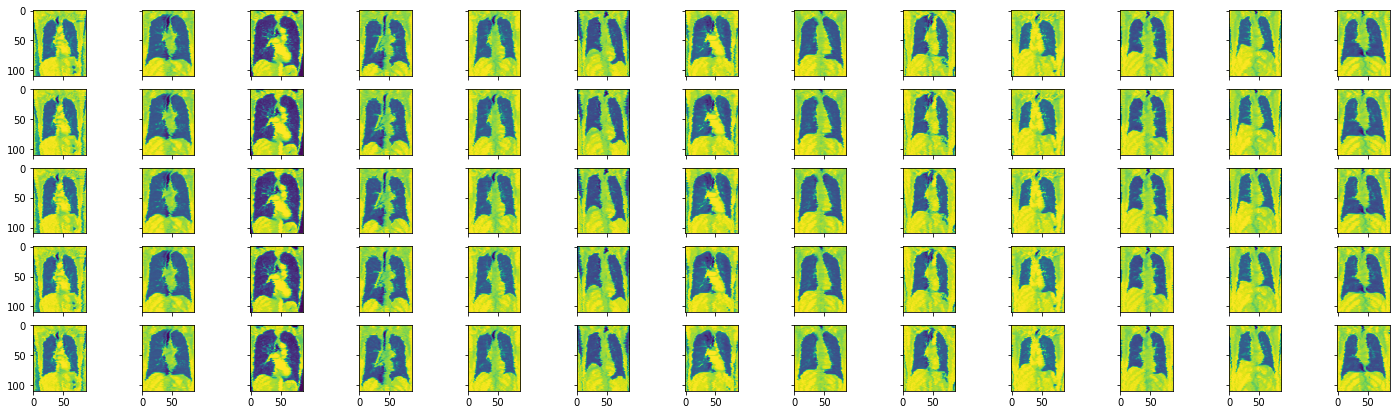

In [ ]:
fig, axe = plt.subplots(5,13, sharex=True, sharey=True, figsize = (25,7))

for i in range(5):
    for j in range(13):
        s = (i*13 + j)*10
        axe[i,j].imshow(x_train_in[s][:,:])

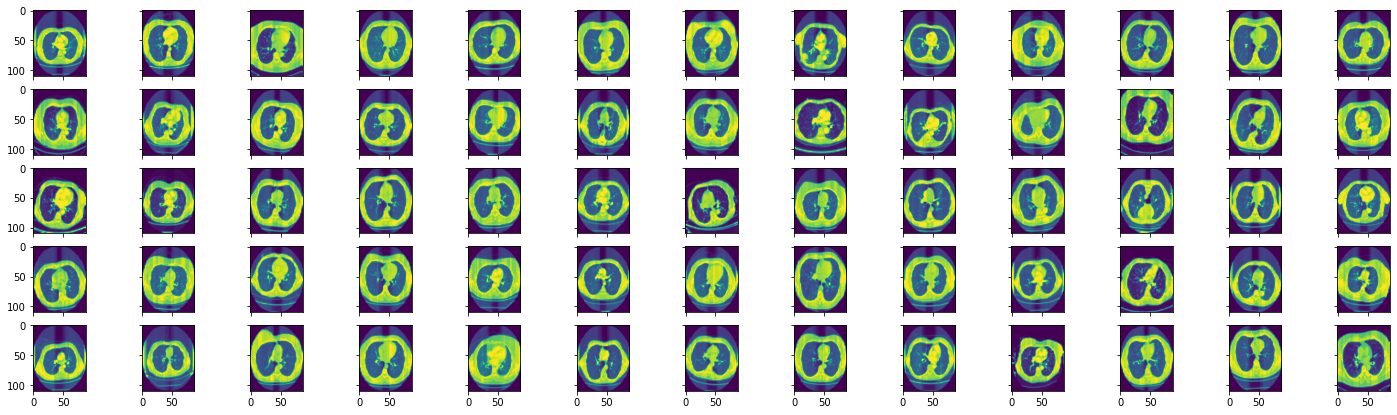

In [ ]:
fig, axe = plt.subplots(5,13, sharex=True, sharey=True, figsize = (25,7))

for i in range(5):
    for j in range(13):
        s = (i*13 + j)*10
        axe[i,j].imshow(y_train_in[s][:,:,55])

In [ ]:
def get_new_x_train_in(y_train_in):
  arr = np.arange(109,0,-1)
  new_x_train_in = np.empty((650,88,110))
  for j,imgs in enumerate(y_train_in):
    x_ray = np.zeros((88,110))
    for i in list(arr):
      x_ray += imgs[i,:,:]
    new_x_train_in[j] = x_ray/109
  return new_x_train_in

In [ ]:
new_x_train_in = get_new_x_train_in(y_train_in)

In [ ]:
np.save('new_x_train_in', new_x_train_in)

# hiding few lines

In [ ]:
img = crop_the_image_1(dicom.read_file('/content/CT_Scans/EXP1_blind/1003/1.dcm'))
plt.imshow(img, cmap = 'gray')


In [ ]:
# Image preprocessing
# x_0 = 255 - x_0
# y_0 = 255 - y_0
# x_1 = 255 - x_1
# y_1 = 255 - y_1
# img = dicom.read_file('/content/CT_Scans/EXP1_blind/1003/10.dcm').pixel_array
img_o = crop_the_image_1(dicom.read_file('/content/CT_Scans/EXP1_blind/1003/1.dcm'))
scaler = MinMaxScaler()
# Gaussian blur
img = scaler.fit_transform(img_o)
img = img/(img.max()/255.0)
# img = 255-img
img = cv2.GaussianBlur(img, (5,5), cv2.BORDER_DEFAULT) 

      # get the image histogram

# the below code in string format is just to get the threshold value. The threshold value = 175 found to hold good. So i am not calculating it qagain and again
'''bins_num = 256
hist, bin_edges = np.histogram(img, bins = bins_num)

      # get normalized histogram if required
      # if is_normalized:
      #   hist = np.divide(hist.ravel(), hist.max())

      # calculate centre of bins
bin_mids = (bin_edges[:-1] + bin_edges[1:])/2.0

      # iterate over all thresholds (indices) and get the probablitie w1(t), w2(t)
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

      # get the class means mu0(t)
mean1 = np.cumsum(hist*bin_mids)/weight1

      # get the class means mu1(t)
mean2 = (np.cumsum(hist*bin_mids[::-1])/weight1[::-1])[::-1]     
inter_class_variance = weight1[:-1]*weight2[1:]*(mean1[:-1] - mean2[1:])**2

      # maximize the inter_class_variance function value
index_of_max_val = np.argmax(inter_class_variance)
threshold = bin_mids[:-1][index_of_max_val]'''
      # print("Otsu's algorithum implementation thresholding result : ", threshold)
ostu_threshold, image_result = cv2.threshold(img, 175, 255, cv2.THRESH_BINARY )
fig = plt.figure(figsize = (15,5))
a = fig.add_subplot(1,2,1)
a.set_title('original image')
plt.imshow(img_o, cmap = 'gray')
plt.axis('off')
a = fig.add_subplot(1,2,2)
a.set_title('modified image under GaussianBlur')
plt.imshow(image_result, cmap = 'gray')
plt.axis('off')

In [ ]:
# fig, axe = plt.subplots(5,13, sharex=True, sharey=True, figsize = (25,7))

# for i in range(5):
#     for j in range(13):
#         s = (i*13 + j)*10
#         axe[i,j].imshow(new_x_train_in[s][:,:])

In [ ]:
# y_train_in.min(), y_train_in.max(), new_x_train_in.min(), new_x_train_in.max()

In [ ]:
# def get_augmented_data_1(len_x_train_in, x_train_in, y_train_in):
#   for i in range(len_x_train_in):
#     yield (x_train_in[i], y_train_in[i])

In [ ]:
# x_new = np.empty((65*10*110*88,1))
# y_new = np.empty((65*10*110*88, 110))

In [ ]:
# del x_new, y_new

In [ ]:
# x_train_in = np.load('x_train_in.npy')
# y_train_in = np.load('y_train_in.npy')

In [ ]:
# x_train_in.shape

In [ ]:
# data = get_augmented_data_1(650, x_train_in, y_train_in)

In [ ]:
# del x_train_in, y_train_in

In [ ]:
# height = 110
# length = 110    slices
# width = 88

# hiding closed

In [ ]:
new_y = np.empty((650*110, 88, 110))
new_x = np.empty((650, 88, 110))

In [ ]:
for i in range(650):
  new_x[i,:,:] = new_x_train_in[i]
  for j in range(110):
    new_y[i*110+j,:,:] = y_train_in[i,j,:,:]

In [ ]:
np.save('new_x.npy', new_x)
np.save('new_y.npy', new_y)

In [ ]:
del x_train_in, new_x_train_in, y_train_in

In [ ]:
l = list(np.arange(0,650*110, 110))
temp_x = np.empty((650,9))
temp_y = np.empty((650))
temp_x[:,0:3] = new_x[:,54:57,54]
temp_x[:,3:6] = new_x[:,54:57,55]
temp_x[:,6:9] = new_x[:,54:57,56]

# temp_x[:,1] = new_x[:,0,1]
# temp_x[:,2] = new_x[:,1,0]
for i, j in enumerate(l):
  temp_y[i] = new_y[j+1,55,55]

In [ ]:
t1 = time.time()
# rf = RandomForestRegressor(n_estimators=45)
rf = KNeighborsRegressor(n_neighbors=1)
# rf = Lasso()
# rf = xgb.XGBRegressor()
rf.fit(temp_x, temp_y)
score = rf.score(temp_x,temp_y)
pred = rf.predict(temp_x)
print('score is : ', score)
print(f'time taken : {(time.time() - t1)} seconds')

score is :  1.0
time taken : 0.0518953800201416 seconds


# multi threading

In [ ]:
def train_for_prediction(new_x,new_y, slide):
  global score
  l = list(np.arange(0,650*110, 110))
  dir = '/content/Model_0/' + str(slide)
  try:
    os.makedirs(dir)
  except:
    pass
  for i in range(1,87):
    for j in range(1,109):
      # if (i not in [0,87] and j not in [0,109]):
      # global score
      temp_x = np.empty((650,9))
      temp_y = np.empty((650))
      temp_x[:,0:3] = new_x[:,i-1:i+2 ,j-1]
      temp_x[:,3:6] = new_x[:,i-1:i+2 ,j]
      temp_x[:,6:9] = new_x[:,i-1:i+2 ,j+1]
      new_l = [m+slide for m in l]
      temp_y[:] = new_y[new_l,i,j]
      # score[slide,i,j,:] = cross_val_score(KNeighborsRegressor(n_neighbors=1), temp_x, temp_y)
      knn = KNeighborsRegressor(n_neighbors=1)
      knn.fit(temp_x, temp_y)
      score[slide,i,j] = knn.score(temp_x, temp_y)      # /content/CT_Scans/EXP1_blind/1003
      
      path = dir + '/' + str(i) + '_' + str(j) + '_knn.pkl'
      with open(path, 'wb') as file:
        pickle.dump(knn, file)
      # pickle.dump()
  for m in [0,87]:
    for n in [0,109]:
      temp_x = np.empty((650))
      temp_y = np.empty((650))
      new_l = [z+slide for z in l]
      temp_y[:] = new_y[new_l,m,n]
      knn = KNeighborsRegressor(n_neighbors=1)
      knn.fit(temp_x, temp_y)
      score[slide,m,n] = score[slide,m,n,:] = knn.score(temp_x, temp_y)
      # dir = '/content/Model_0/' + str(slide)
      path = dir + '/' + str(m) + '_' + str(n) + '_knn.pkl'
      # pickle.dump(knn,path, 'wb')
      # try:
      #   os.makedirs(dir)
      # except:
      #   pass
      with open(path, 'wb') as file:
        pickle.dump(knn, file)


#####       
score = np.empty((110,88,110))
global score
#####

In [ ]:
#####       
score = np.empty((110,88,110))
global score
#####
for slide in range(110):
  t = threading.Thread(target = train_for_prediction, args = (new_x,new_y,slide))
  t.start()

In [ ]:
#####  

score = np.empty((110,88,110))
global score
global done_or_not

#####

list_3 = list(set.union(set(np.arange(6,10,1)), set(np.arange(100,105,1))))
list_4 = list(set.union(set(np.arange(10,15,1)), set(np.arange(91,100,1))))
list_5 = list(set.union(set(np.arange(15,38,1)), set(np.arange(83,91, 1))))

i_range_1 = list(np.arange(30,60,1))
i_range_2 = list(np.arange(20,66,1))
i_range_3 = list(np.arange(15,70,1))
i_range_4 = list(np.arange(10,80,1)) 
i_range_5 = list(np.arange( 5,85,1))
i_range_6 = list(np.arange( 1,87,1))


for slide in range(55,110):
  if slide in [0,1,109]:
    i_range = i_range_1

  elif slide in [2,3,4,5,105,106,107,108]:
    i_range = i_range_2

  elif slide in list_3:
    i_range = i_range_3

  elif slide in list_4:
    i_range = i_range_4

  elif slide in list_5:
    i_range = i_range_5
  else:
    i_range = i_range_6

  t = threading.Thread(target = train_for_prediction, args = (new_x,new_y,slide, i_range))
  globals()['slide_{}'.format(slide)] = t
  t.start()

for slide in range(55,110):
  globals()['slide_{}'.format(slide)].join()


# def next_code_to_execute_or_not(done_or_not):
#   if done_or_not:
#     return True
#   else:
#     time.sleep(10)
#     return False

# while not done_or_not:
#   if next_code_to_execute_or_not(done_or_not):
#     break

In [ ]:
fig, axe = plt.subplots(ncols=11, nrows=10, figsize = (25,22))      # (110,88,110,5)
for i in range(10):
  for j in range(11):
    s = i*11 + j
    min_score_per_col = [np.min(score[s,:,k]) for k in range(110)]
    mean_score_per_col = [np.mean(score[s,:,k]) for k in range(110)]
    max_score_per_col = [np.max(score[s,:,k]) for k in range(110)]
    axe[i,j].plot(min_score_per_col, color = 'red', label = 'min')
    axe[i,j].plot(mean_score_per_col, color = 'blue', label = 'mean')
    axe[i,j].plot(max_score_per_col, color = 'green', label = 'max')
# plt.legend()

# multi threading ends here

# Predictions

In [ ]:
def predict_3D_image(x, s):
  global y
  temp_y = np.empty((110,110))
  with open('/content/Model_1/0/Droped_and_kept_col/droped_col.pkl', 'rb') as file:
    droped_col = pickle.load(file)
  with open('/content/Model_1/0/Droped_and_kept_col/kept_col.pkl', 'rb') as file:
    kept_col = pickle.load(file)
  kept_col_new = list()
  for i in kept_col:
    kept_col_new += i
  kept_col_new = list(set(kept_col_new))
  for i, k in enumerate(kept_col_new):
    for j in range(110):
      #######
      if (k not in [0,109]) and (j not in [0,109]):
        temp_x = np.empty((650,9))
        temp_y = np.empty((650))
        temp_x[:,0:3] = x[i-1:i+2 ,j-1]
        temp_x[:,3:6] = x[i-1:i+2 ,j]
        temp_x[:,6:9] = x[i-1:i+2 ,j+1]
      #######
      path = '/content/Model_0/' + str(slide) + '/' + str(i) + '_' + str(j) + '_knn.pkl'
      with open(path, 'rb') as file:
        knn = pickle.load(file)
      temp_y[k,j] = knn.predict(temp_x)
  # temp_y = cv2.rotate(temp_y, cv2.ROTATE_90_CLOCKWISE)
  temp_y = pd.DataFrame(temp_y.T[::-1])
  for i,j in enumerate(droped_col):
    with open('/content/Model_1/0/models/' +str(j) + '_knn.pkl', 'rb') as file:
      knn = pickle.load(file)
    temp_y[:,j] = knn.predict(temp_y[kept_col[i]])
  y[:,:,s] = temp_y

In [ ]:
y = np.empty((110,110,110))
global y
x = new_x[0]
for s in range(110):
  t = threading.Thread(target = predict_3D_image, args = (x,s))
  t.start()
# predict_3D_image(x, s)